cuda
['Bears', 'Pandas']
['Bears', 'Pandas']


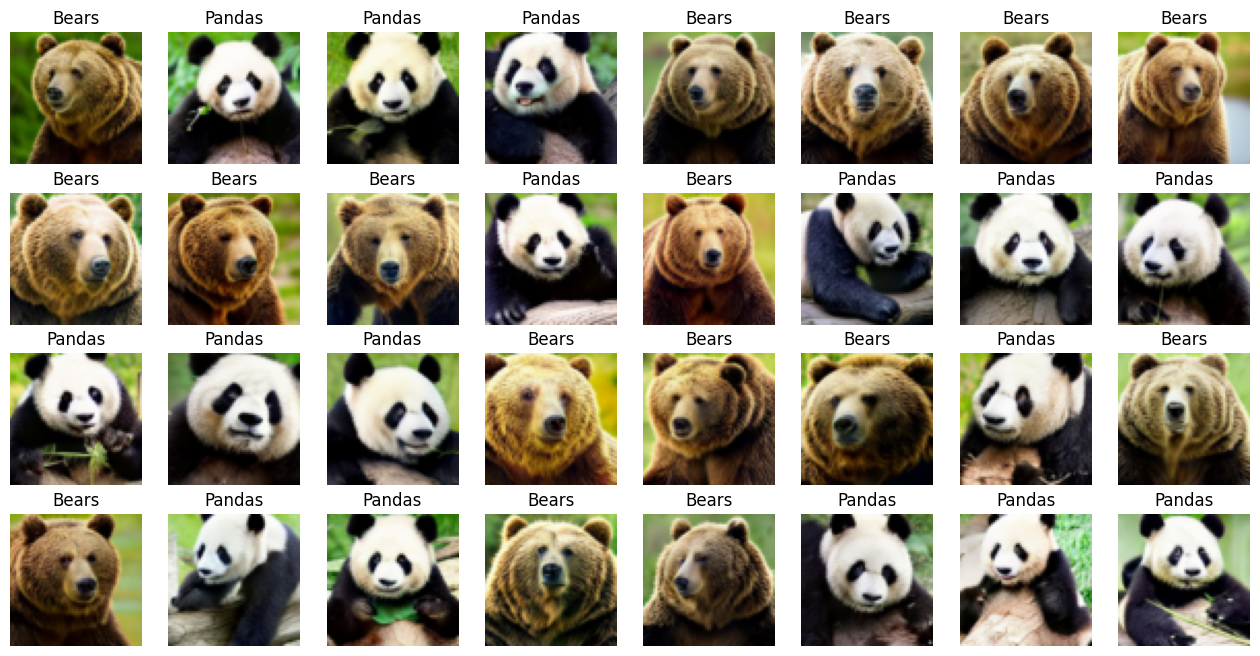

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from torchvision import transforms,datasets
import os
from sklearn.metrics import confusion_matrix

device = ("cuda" if torch.cuda.is_available() else "cpu")
print(device)



train_dir = "data/Train"
print(os.listdir(train_dir))
test_dir = "data/Test"
print(os.listdir(test_dir))


labels = ['Bears', 'Pandas']


transformed_data = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
    ])



train_dataset = datasets.ImageFolder(train_dir,transform=transformed_data)
test_dataset = datasets.ImageFolder(test_dir,transform=transformed_data)



learning_rate = 0.001
BATCH_SIZE = 32
epochs = 5
train_dataloader = torch.utils.data.DataLoader(train_dataset,batch_size=BATCH_SIZE,shuffle=True)
test_dataloader=  torch.utils.data.DataLoader(test_dataset,batch_size=BATCH_SIZE,shuffle=False)

def img_inv(image):
    image = image.numpy().transpose((1,2,0))
    mean = np.array([0.485,0.456,0.406])
    std = np.array([0.229,0.224,0.225])
    image = image * std + mean
    return np.clip(image,0,1)


images,labels = next(iter(train_dataloader))

fig,axs = plt.subplots(4,8,figsize=(16,8))

for i,ax in enumerate(axs.flat):
    image = img_inv(images[i])
    ax.imshow(image)
    ax.set_title(train_dataset.classes[labels[i]])
    ax.axis("off")
plt.show()


In [3]:

class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.con1 = nn.Conv2d(3, 32,kernel_size=3,padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2,2)
        
        self.con2 = nn.Conv2d(32, 64, kernel_size=3,padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2,2)
        
        self.con3 = nn.Conv2d(64, 128, kernel_size=3,padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(2,2)
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(8*8*128, 512),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, 2)
            )
        
        
    def forward(self,x):
        x = self.pool1(F.relu(self.bn1(self.con1(x))))
        x = self.pool2(F.relu(self.bn2(self.con2(x))))
        x = self.pool3(F.relu(self.bn3(self.con3(x))))
        x = self.classifier(x)
        return x


model = Net()        
model.to(device)


optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
criterion = nn.CrossEntropyLoss()
total_steps = len(train_dataloader)


for epoch in range(epochs):
    for i,(images,labels) in enumerate(train_dataloader):
        images,labels = images.to(device),labels.to(device)
        outputs = model(images)
        loss = criterion(outputs,labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        

        print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
               .format(epoch+1, epochs, i+1, total_steps, loss.item()))

Epoch [1/5], Step [1/16], Loss: 0.7364
Epoch [1/5], Step [2/16], Loss: 4.8647
Epoch [1/5], Step [3/16], Loss: 3.0345
Epoch [1/5], Step [4/16], Loss: 0.9102
Epoch [1/5], Step [5/16], Loss: 0.1767
Epoch [1/5], Step [6/16], Loss: 0.0011
Epoch [1/5], Step [7/16], Loss: 0.0002
Epoch [1/5], Step [8/16], Loss: 0.2305
Epoch [1/5], Step [9/16], Loss: 0.0560
Epoch [1/5], Step [10/16], Loss: 0.1148
Epoch [1/5], Step [11/16], Loss: 0.0000
Epoch [1/5], Step [12/16], Loss: 0.0004
Epoch [1/5], Step [13/16], Loss: 0.0001
Epoch [1/5], Step [14/16], Loss: 0.0000
Epoch [1/5], Step [15/16], Loss: 0.0004
Epoch [1/5], Step [16/16], Loss: 0.0000
Epoch [2/5], Step [1/16], Loss: 0.1022
Epoch [2/5], Step [2/16], Loss: 0.0000
Epoch [2/5], Step [3/16], Loss: 0.0004
Epoch [2/5], Step [4/16], Loss: 0.0000
Epoch [2/5], Step [5/16], Loss: 0.1957
Epoch [2/5], Step [6/16], Loss: 0.0999
Epoch [2/5], Step [7/16], Loss: 0.0000
Epoch [2/5], Step [8/16], Loss: 0.0000
Epoch [2/5], Step [9/16], Loss: 0.0000
Epoch [2/5], Step 

In [4]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    y_pred = []
    y_test = []
    for images,labels in test_dataloader:
        images,labels = images.to(device),labels.to(device)
        outputs = model(images)
        _,preds = torch.max(outputs.data,1)
        y_pred.extend(preds.cpu().numpy())
        y_test.extend(labels.cpu().numpy())
        total += labels.size(0)
        correct += (preds == labels).sum().item()
        
test_acc = 100 * correct / total
print(F"Testing Accuracy: {test_acc:.2f}%")

Testing Accuracy: 100.00%


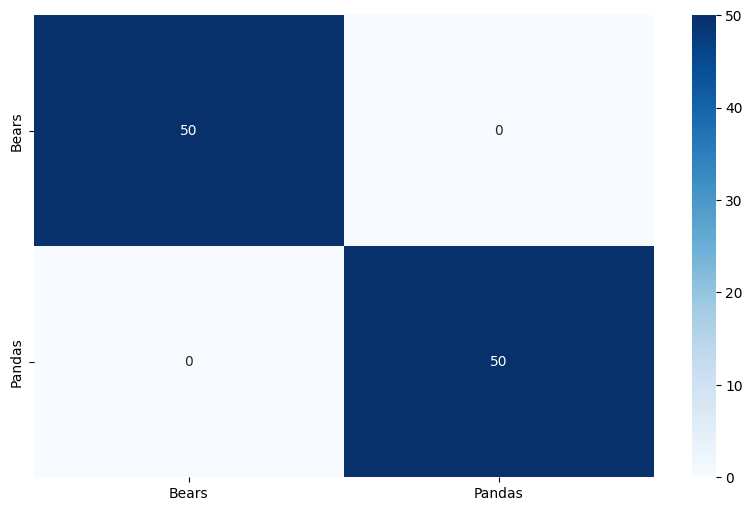

In [5]:

def plot_confusion_matrix(y_test,y_pred):
    cm = confusion_matrix(y_test, y_pred)
    return sns.heatmap(cm,fmt='d',cmap="Blues",annot=True,xticklabels=['Bears','Pandas'],yticklabels=['Bears','Pandas'])



plt.figure(figsize=(10,6))
plot_confusion_matrix(y_test, y_pred)
plt.show()



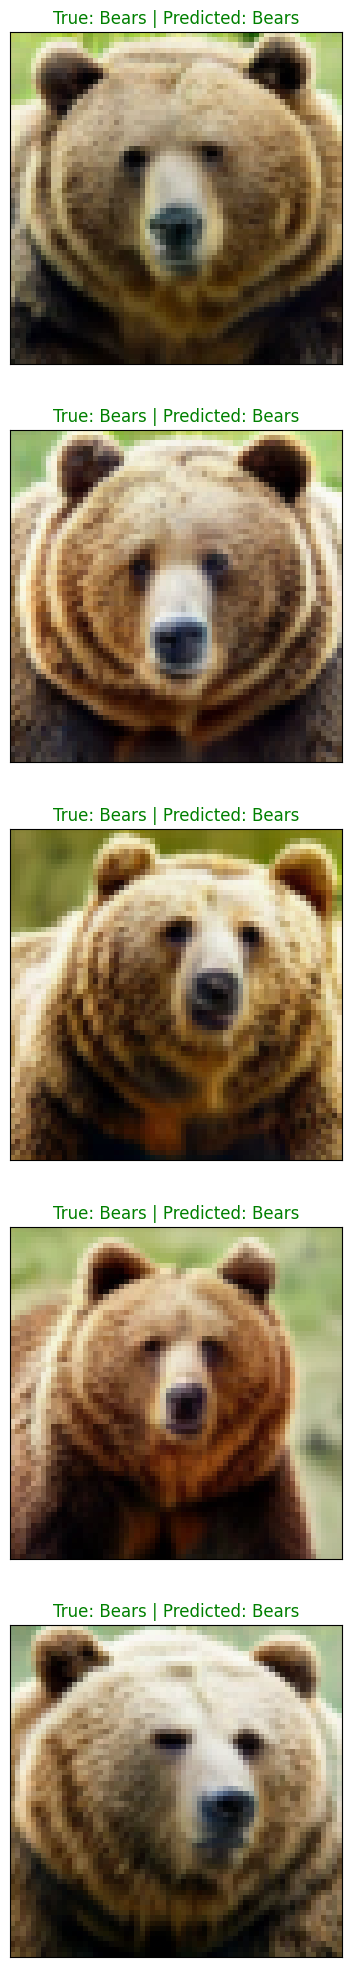

In [6]:
rand_indices = np.random.choice(len(y_pred), size=min(5, len(y_pred)), replace=False)
plt.figure(figsize=(10,5*len(rand_indices)))
for i, index in enumerate(rand_indices):
    image = img_inv(test_dataset[index][0])
    plt.subplot(len(rand_indices),1, i + 1)
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    predicted_class = test_dataset.classes[y_pred[index]]
    true_class = test_dataset.classes[y_test[index]]
    color = 'green' if predicted_class == true_class else 'red'
    plt.title(f'True: {true_class} | Predicted: {predicted_class}', color=color, fontsize=12)


plt.show()

